# Imports

In [66]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

# Hydrogen Atom

We will start by studying the Hydrogen Atom:

$$
\begin{align*}

H &= -\frac12\nabla^2 - \frac1r
\\\\


\psi(\textbf r) &= e^{-\beta r}

\end{align*}
$$

# Metropolis Sampling Position

In [67]:
def rvec(pos: np.ndarray) -> float:
    return np.sqrt(pos[0]**2 + pos[1]**2 + pos[2]**2)


def r3(x: float, y: float, z:float) -> float:
    return np.sqrt(x**2 + y**2 + z**2)


def samplePos(M: int, beta: float, delta: float = 0.5) -> np.ndarray:
    """
        Samples M positions taking as the desired distribution psi, assuming psi is real!
    """

    # List of samples
    samples = np.zeros((M), dtype=float)

    # Starting position
    x, y, z = 10, 0.1, 0.01
    rpos = r3(x, y, z)
    samples[0] = rpos

    logpsi = -beta * rpos

    # Metropolis Loop
    succ = 0
    for attempt in range(M-1):
        xp = x + delta*(np.random.random() - 0.5)
        yp = y + delta*(np.random.random() - 0.5)
        zp = z + delta*(np.random.random() - 0.5)

        rposp = r3(xp, yp, zp)
        logpsip = -beta * rposp

        accept = min(1, np.exp(2 * (logpsip - logpsi)))

        # Accept step
        if accept > np.random.random():
            succ += 1

            x, y, z = xp, yp, zp
            rpos = rposp
            logpsi = logpsip
        
        # Save state
        samples[attempt+1] = rpos
    
    print(f"Acceptance: {succ / attempt}")
    return samples

In [68]:
def sampleNeff(data: np.ndarray, k1: int = 0, icutoff: int = 200) -> int:
    # Equilibriation
    data = data[k1:]

    # Raw data
    Neq = len(data)

    # Calculate Stats
    ave = np.mean(data)
    var = np.var(data, mean=ave, ddof=1)

    # Calculate autocorrelations and cutoff
    autocorr = np.array([np.mean((data[: Neq-i]-ave) * (data[i:]-ave)) for i in range(1, icutoff+1)]) / (var)

    # Calculate autocorrelation time (sum until we find some negative number)
    timecorr = 1 + 2 * np.sum(autocorr * (np.arange(len(autocorr)) < np.argmax(autocorr < 0)))

    Neff = Neq / timecorr

    return ave, var, timecorr, Neff

## No Reweighting

Beta = 0.200
Acceptance: 0.8865182024269903
Energy = -0.19123106979854107
Variance on Energy = 0.037841127458848316
Correlation Time: 1.0
Neff: 13500.0
Standard Deviation on Mean Energy = 0.0016742301151374647

Beta = 0.300
Acceptance: 0.826776903587145
Energy = -0.2487902849063413
Variance on Energy = 0.037657055109706246
Correlation Time: 37.0778069162961
Neff: 364.09920442372777
Standard Deviation on Mean Energy = 0.010169821071276449

Beta = 0.400
Acceptance: 0.7859714628617149
Energy = -0.3163854714596539
Variance on Energy = 0.044376341437188216
Correlation Time: 18.675288865720827
Neff: 722.8803847194964
Standard Deviation on Mean Energy = 0.007835063615725793

Beta = 0.500
Acceptance: 0.7188291772236298
Energy = -0.3923724445109668
Variance on Energy = 0.05307372430619741
Correlation Time: 12.611853675467449
Neff: 1070.421553198018
Standard Deviation on Mean Energy = 0.007041454210927055

Beta = 0.600
Acceptance: 0.6668889185224697
Energy = -0.4153726207520264
Variance on Energ

/tmp/ipykernel_1085/3773701406.py:13: RuntimeWarning: invalid value encountered in divide
  autocorr = np.array([np.mean((data[: Neq-i]-ave) * (data[i:]-ave)) for i in range(1, icutoff+1)]) / (var)


Acceptance: 0.4336578210428057
Energy = -0.46989873276916916
Variance on Energy = 0.06240276235684449
Correlation Time: 15.379500825440234
Neff: 877.7918186830076
Standard Deviation on Mean Energy = 0.008431525213180989

Beta = 1.300
Acceptance: 0.40958794505934126
Energy = -0.45429106246175494
Variance on Energy = 0.11348088296865569
Correlation Time: 15.374937703138908
Neff: 878.0523382051737
Standard Deviation on Mean Energy = 0.011368447257538208

Beta = 1.400
Acceptance: 0.3776503533804507
Energy = -0.3736953595112377
Variance on Energy = 1.2303530016099156
Correlation Time: 28.68839140117653
Neff: 470.5736132506319
Standard Deviation on Mean Energy = 0.0511329773070306

Beta = 1.500
Acceptance: 0.34424589945326045
Energy = -0.34264514430818654
Variance on Energy = 0.6928710849418765
Correlation Time: 22.52604399794582
Neff: 599.3062963577219
Standard Deviation on Mean Energy = 0.034001791395405614

Beta = 1.600
Acceptance: 0.3351113481797573
Energy = -0.3532083510812681
Variance 

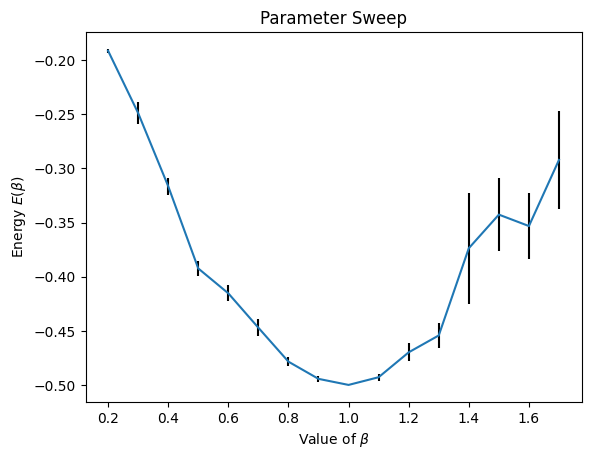

In [69]:
# Parameters
sampleM = 15000
discard = 1500
delta = 2.4

# Sweep Variational Parameter
betaMin = 0.2
betaMax = 1.7

Ebeta = []
Estd = []
Evar = []
bbRange = np.linspace(betaMin, betaMax, 16)
for betaStart in bbRange:
    print(f"Beta = {betaStart:.3f}")
    Rs = samplePos(sampleM, betaStart, delta)
    Rs = Rs[discard:]
    Ekin = -0.5*betaStart*(betaStart - 2/Rs)
    Epot = - 1.0 / Rs
    El = Ekin + Epot
    ave, var, timecorr, Neff = sampleNeff(El)

    with open(f"./Outputs/h-out-beta={betaStart:.2f}.txt", "w") as file:
        for i in range(len(El)):
            file.write(f"{El[i]}\t{Ekin[i]}\t{Epot[i]}\n")

    Evar += [var]
    Estd += [np.sqrt(var) / np.sqrt(Neff)]
    Ebeta += [ave]
    print(f"Energy = {Ebeta[-1]}")
    print(f"Variance on Energy = {Evar[-1]}")
    print(f"Correlation Time: {timecorr}")
    print(f"Neff: {Neff}")
    print(f"Standard Deviation on Mean Energy = {Estd[-1]}")
    print("")

print(f"Best beta: {bbRange[Ebeta.index(np.min(Ebeta))]}")
plt.errorbar(bbRange, Ebeta, yerr=Estd, ecolor="black")
plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")

plt.savefig(f"./Plots/h-out-sweep.png")

# With Reweighting

BetaMid = 2.000
Acceptance: 0.4511585264210702

BetaMid = 1.400
Acceptance: 0.5753458909818303

BetaMid = 1.100
Acceptance: 0.6532755459243207

BetaMid = 1.000
Acceptance: 0.6951158526421071

BetaMid = 1.000
Acceptance: 0.6857809634939157

Final beta: 0.9375
Minimum energy: -0.5006879817413108


/tmp/ipykernel_1085/3773701406.py:13: RuntimeWarning: invalid value encountered in divide
  autocorr = np.array([np.mean((data[: Neq-i]-ave) * (data[i:]-ave)) for i in range(1, icutoff+1)]) / (var)


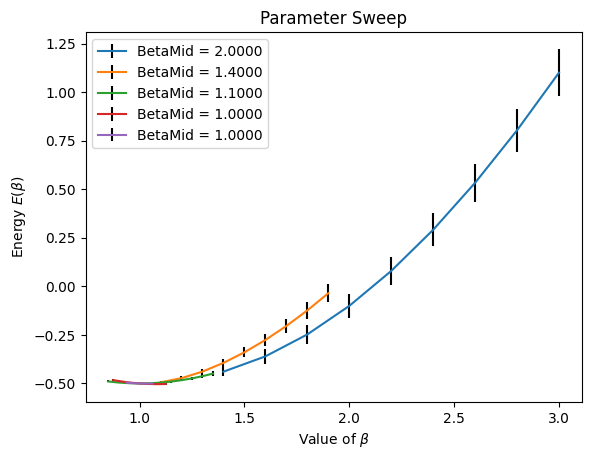

In [70]:
# Sampling Parameters
sampleM = 12000
discard = 2000

delta = 1.4

# Target Function is energy + stdW * std
stdW = 2

# Starting Variational Parameters
betaStart = 2

betaRange = 1
betaSamples = 11
betaMult = 0.5

betaSteps = 5

betaMid = betaStart
for _ in range(betaSteps):
    betaMin = betaMid - betaRange
    betaMax = betaMid + betaRange

    Ebeta = []
    Estd = []
    bb = []
    bbRange = np.linspace(betaMin, betaMax, betaSamples)
    
    print(f"BetaMid = {betaMid:.3f}")
    Rs = samplePos(sampleM, betaMid, delta=delta)
    Rs = Rs[discard:]
    El = -0.5*betaMid*(betaMid - 2/Rs) - 1.0 / Rs
    ave, var, timecorr, Neff = sampleNeff(El)
    for beta in bbRange:
        # Calculate weights
        ww = np.exp(-2 * (beta - betaMid) * Rs)

        # Effective number of points
        m = ((np.sum(ww))**2 / np.sum(ww**2)) / len(Rs)
        if m < 0.5:
            continue

        bb += [beta]

        El = -0.5*beta*(beta - 2/Rs) - 1.0 / Rs
        Estd += [np.std(El) / np.sqrt(Neff)]
        Ebeta += [(np.sum(El * ww)) / (np.sum(ww))]
    
    # Plot results
    plt.errorbar(bb, Ebeta, yerr=Estd, ecolor="black", label=f"BetaMid = {betaMid:.4f}")
    
    # Target function
    target = [Ebeta[i] + stdW * Estd[i] for i in range(len(bb))]

    betaMini = bb[target.index(min(target))]
    betaMid = betaMini
    betaRange *= betaMult
    print("")


print(f"Final beta: {betaMini}")
print(f"Minimum energy: {min(Ebeta)}")

plt.xlabel("Value of $\\beta$")
plt.ylabel("Energy $E(\\beta)$")
plt.title("Parameter Sweep")
plt.legend()